In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json
from keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from numpy.random import seed
from tensorflow.random import set_seed


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/activity_labels.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/README.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/features_info.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/features.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/subject_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/y_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/X_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/body_acc_y_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/total_acc_z_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/body_acc_z_test.txt
/kaggle/input/human-activity-recognition/UCI_HAR_Dataset/test/Inertial Signals/body_gyr

In [2]:
activities = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

In [3]:

def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    files = list()
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    X = load_group(files, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    X_train, y_train = load_dataset_group('train', prefix)
    X_test, y_test = load_dataset_group('test', prefix)
    y_train = y_train - 1
    y_test = y_test - 1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

In [4]:
def create_model(model):
    classifier = KerasClassifier(model, verbose=2)
    return classifier

In [5]:

def grid(classifier):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)

    batch_size = [32]
    epochs = [10]
    validation_split = [0.1]
    
    param_grid = dict(batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=1, cv=5, return_train_score=True, verbose=2)
    
    grid_result = grid.fit(X_train_subset, y_train_subset)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return grid_result


In [6]:
def evaluate_model(X_train, y_train, X_test, y_test, params, model):
    epochs, batch_size = params["epochs"], params["batch_size"]
    es =EarlyStopping(monitor='val_loss', patience=5)
    classifier=model()
    history = classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.1, callbacks=[es])
    _, accuracy = classifier.evaluate( X_test, y_test, batch_size=batch_size, verbose=0)
    return history, accuracy, classifier

In [7]:
def run_model(model, grid_result):
    history, score, classifier = evaluate_model(X_train, y_train, X_test, y_test, grid_result.best_params_, model)
    score = score * 100.0
    print('> %.3f' % (score))
    results=pd.DataFrame(history.history, index=history.epoch)
    return results, classifier

In [8]:
def plot_loss(results):
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)
    fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(results['loss'], label='train', )
    axes[0].plot(results['val_loss'], label='test')
    axes[0].legend()
    axes[1].set_title('Accuracy')
    axes[1].plot(results['accuracy'], label='train')
    axes[1].plot(results['val_accuracy'], label='test')
    axes[1].legend()
    plt.show()
    return

In [9]:
def run(model):
    classifier=create_model(model)
    grid_result=grid(classifier)
    results, classifier=run_model(model, grid_result)
    plot_loss(results)
    return classifier

In [10]:
X_train, y_train, X_test, y_test = load_dataset(prefix="../input/human-activity-recognition/UCI_HAR_Dataset/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 6)
Test Set:
X_test (2947, 128, 9) y_test (2947, 6)


### LSTM Model

In [11]:
def model1():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] batch_size=32, epochs=10, validation_split=0.1 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
34/34 - 1s - loss: 1.5085 - accuracy: 0.3582 - val_loss: 1.3109 - val_accuracy: 0.5339
Epoch 2/10
34/34 - 0s - loss: 1.1233 - accuracy: 0.5255 - val_loss: 1.1067 - val_accuracy: 0.4915
Epoch 3/10
34/34 - 0s - loss: 0.9949 - accuracy: 0.5794 - val_loss: 1.2597 - val_accuracy: 0.4746
Epoch 4/10
34/34 - 0s - loss: 0.9588 - accuracy: 0.5917 - val_loss: 0.9410 - val_accuracy: 0.6610
Epoch 5/10
34/34 - 0s - loss: 0.9963 - accuracy: 0.6096 - val_loss: 1.1432 - val_accuracy: 0.4661
Epoch 6/10
34/34 - 0s - loss: 0.9770 - accuracy: 0.6059 - val_loss: 0.8481 - val_accuracy: 0.6864
Epoch 7/10
34/34 - 0s - loss: 0.7299 - accuracy: 0.7202 - val_loss: 0.7325 - val_accuracy: 0.7458
Epoch 8/10
34/34 - 0s - loss: 0.6581 - accuracy: 0.7297 - val_loss: 0.7992 - val_accuracy: 0.6949
Epoch 9/10
34/34 - 0s - loss: 0.5889 - accuracy: 0.7703 - val_loss: 0.5827 - val_accuracy: 0.7712
Epoch 10/10
34/34 - 0s - loss: 0.5622 - accuracy: 0.7628 - val_loss: 0.5606 - val_accuracy: 0.7712
10/10 - 0s - loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


Epoch 1/10
34/34 - 1s - loss: 1.5220 - accuracy: 0.3374 - val_loss: 1.3091 - val_accuracy: 0.5932
Epoch 2/10
34/34 - 0s - loss: 1.1636 - accuracy: 0.5151 - val_loss: 1.1173 - val_accuracy: 0.5169
Epoch 3/10
34/34 - 0s - loss: 1.0378 - accuracy: 0.5539 - val_loss: 1.0459 - val_accuracy: 0.5593
Epoch 4/10
34/34 - 0s - loss: 0.9551 - accuracy: 0.5794 - val_loss: 0.8289 - val_accuracy: 0.7034
Epoch 5/10
34/34 - 0s - loss: 0.8719 - accuracy: 0.6418 - val_loss: 0.7994 - val_accuracy: 0.6780
Epoch 6/10
34/34 - 0s - loss: 0.7742 - accuracy: 0.6730 - val_loss: 0.7904 - val_accuracy: 0.7288
Epoch 7/10
34/34 - 0s - loss: 0.7375 - accuracy: 0.7042 - val_loss: 0.6567 - val_accuracy: 0.7203
Epoch 8/10
34/34 - 0s - loss: 0.6137 - accuracy: 0.7193 - val_loss: 0.6281 - val_accuracy: 0.7458
Epoch 9/10
34/34 - 0s - loss: 0.6030 - accuracy: 0.7514 - val_loss: 0.5836 - val_accuracy: 0.7458
Epoch 10/10
34/34 - 0s - loss: 0.5120 - accuracy: 0.7921 - val_loss: 0.5561 - val_accuracy: 0.7288
10/10 - 0s - loss: 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.0s finished


Epoch 1/10
42/42 - 1s - loss: 1.4733 - accuracy: 0.3885 - val_loss: 1.2008 - val_accuracy: 0.5578
Epoch 2/10
42/42 - 0s - loss: 1.1263 - accuracy: 0.5215 - val_loss: 1.1243 - val_accuracy: 0.5374
Epoch 3/10
42/42 - 0s - loss: 1.0165 - accuracy: 0.5518 - val_loss: 1.0078 - val_accuracy: 0.6054
Epoch 4/10
42/42 - 0s - loss: 0.8895 - accuracy: 0.6259 - val_loss: 0.9309 - val_accuracy: 0.6327
Epoch 5/10
42/42 - 0s - loss: 0.8015 - accuracy: 0.6659 - val_loss: 0.9675 - val_accuracy: 0.5578
Epoch 6/10
42/42 - 0s - loss: 0.7310 - accuracy: 0.6939 - val_loss: 0.6935 - val_accuracy: 0.7279
Epoch 7/10
42/42 - 0s - loss: 0.6435 - accuracy: 0.7400 - val_loss: 0.6606 - val_accuracy: 0.7687
Epoch 8/10
42/42 - 0s - loss: 0.5788 - accuracy: 0.7642 - val_loss: 0.5972 - val_accuracy: 0.7551
Epoch 9/10
42/42 - 0s - loss: 0.5476 - accuracy: 0.7649 - val_loss: 0.6657 - val_accuracy: 0.7415
Epoch 10/10
42/42 - 0s - loss: 0.5220 - accuracy: 0.7823 - val_loss: 0.6103 - val_accuracy: 0.7551
Best: 0.770068 usin

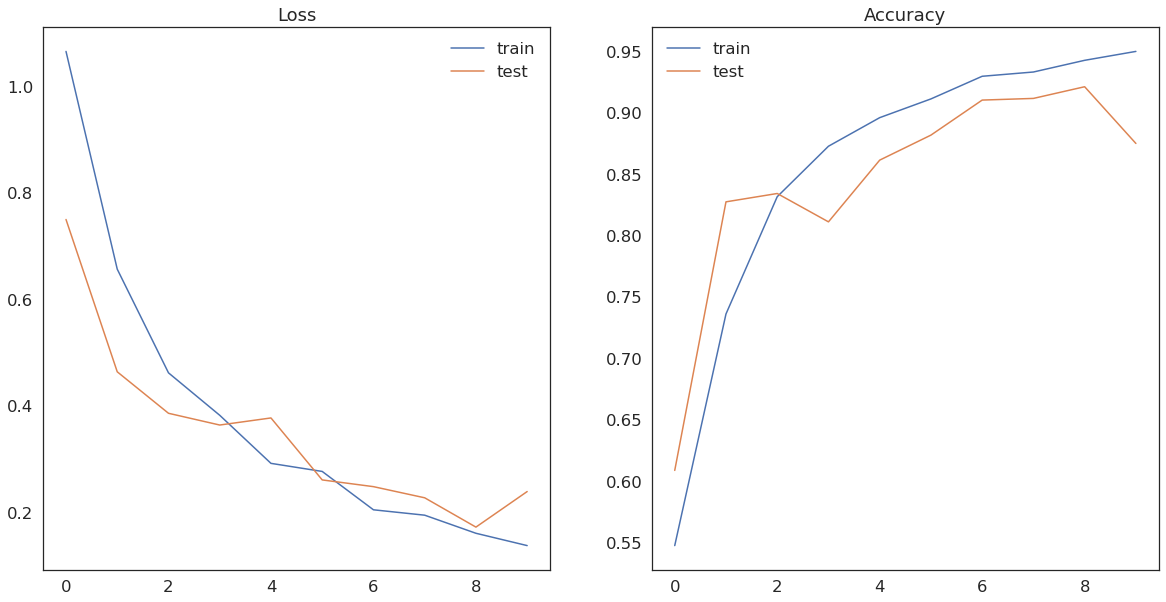

In [12]:
classifier1=run(model1)

### CNN Model

In [13]:
def model2():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] batch_size=32, epochs=10, validation_split=0.1 ..................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


34/34 - 0s - loss: 0.8605 - accuracy: 0.6474 - val_loss: 0.5821 - val_accuracy: 0.8051
Epoch 2/10
34/34 - 0s - loss: 0.4686 - accuracy: 0.8147 - val_loss: 0.4411 - val_accuracy: 0.7966
Epoch 3/10
34/34 - 0s - loss: 0.3325 - accuracy: 0.8592 - val_loss: 0.3716 - val_accuracy: 0.8729
Epoch 4/10
34/34 - 0s - loss: 0.2448 - accuracy: 0.9093 - val_loss: 0.2854 - val_accuracy: 0.9153
Epoch 5/10
34/34 - 0s - loss: 0.1861 - accuracy: 0.9348 - val_loss: 0.2614 - val_accuracy: 0.8983
Epoch 6/10
34/34 - 0s - loss: 0.1351 - accuracy: 0.9490 - val_loss: 0.2296 - val_accuracy: 0.9068
Epoch 7/10
34/34 - 0s - loss: 0.1162 - accuracy: 0.9527 - val_loss: 0.2356 - val_accuracy: 0.8898
Epoch 8/10
34/34 - 0s - loss: 0.1170 - accuracy: 0.9490 - val_loss: 0.2181 - val_accuracy: 0.9153
Epoch 9/10
34/34 - 0s - loss: 0.1133 - accuracy: 0.9556 - val_loss: 0.1804 - val_accuracy: 0.9237
Epoch 10/10
34/34 - 0s - loss: 0.1092 - accuracy: 0.9537 - val_loss: 0.2132 - val_accuracy: 0.9407
10/10 - 0s - loss: 0.2862 - ac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


34/34 - 0s - loss: 0.9078 - accuracy: 0.6125 - val_loss: 0.6273 - val_accuracy: 0.7797
Epoch 2/10
34/34 - 0s - loss: 0.4668 - accuracy: 0.8034 - val_loss: 0.4586 - val_accuracy: 0.8475
Epoch 3/10
34/34 - 0s - loss: 0.3355 - accuracy: 0.8639 - val_loss: 0.3591 - val_accuracy: 0.8983
Epoch 4/10
34/34 - 0s - loss: 0.2156 - accuracy: 0.9178 - val_loss: 0.3007 - val_accuracy: 0.9153
Epoch 5/10
34/34 - 0s - loss: 0.2349 - accuracy: 0.9036 - val_loss: 0.2676 - val_accuracy: 0.9322
Epoch 6/10
34/34 - 0s - loss: 0.1488 - accuracy: 0.9367 - val_loss: 0.2578 - val_accuracy: 0.9237
Epoch 7/10
34/34 - 0s - loss: 0.1839 - accuracy: 0.9272 - val_loss: 0.2667 - val_accuracy: 0.8814
Epoch 8/10
34/34 - 0s - loss: 0.1452 - accuracy: 0.9376 - val_loss: 0.2017 - val_accuracy: 0.9492
Epoch 9/10
34/34 - 0s - loss: 0.1197 - accuracy: 0.9442 - val_loss: 0.1755 - val_accuracy: 0.9576
Epoch 10/10
34/34 - 0s - loss: 0.1125 - accuracy: 0.9509 - val_loss: 0.1680 - val_accuracy: 0.9576
10/10 - 0s - loss: 0.1551 - ac

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s finished


42/42 - 0s - loss: 0.7962 - accuracy: 0.6515 - val_loss: 0.5684 - val_accuracy: 0.7755
Epoch 2/10
42/42 - 0s - loss: 0.3775 - accuracy: 0.8473 - val_loss: 0.4369 - val_accuracy: 0.8503
Epoch 3/10
42/42 - 0s - loss: 0.3013 - accuracy: 0.8806 - val_loss: 0.2883 - val_accuracy: 0.8980
Epoch 4/10
42/42 - 0s - loss: 0.1749 - accuracy: 0.9335 - val_loss: 0.2028 - val_accuracy: 0.9456
Epoch 5/10
42/42 - 0s - loss: 0.1385 - accuracy: 0.9494 - val_loss: 0.2254 - val_accuracy: 0.8912
Epoch 6/10
42/42 - 0s - loss: 0.1348 - accuracy: 0.9441 - val_loss: 0.1705 - val_accuracy: 0.9456
Epoch 7/10
42/42 - 0s - loss: 0.1288 - accuracy: 0.9509 - val_loss: 0.1826 - val_accuracy: 0.9184
Epoch 8/10
42/42 - 0s - loss: 0.1173 - accuracy: 0.9501 - val_loss: 0.1669 - val_accuracy: 0.9456
Epoch 9/10
42/42 - 0s - loss: 0.1154 - accuracy: 0.9486 - val_loss: 0.1688 - val_accuracy: 0.9388
Epoch 10/10
42/42 - 0s - loss: 0.1095 - accuracy: 0.9486 - val_loss: 0.1479 - val_accuracy: 0.9592
Best: 0.925850 using {'batch_s

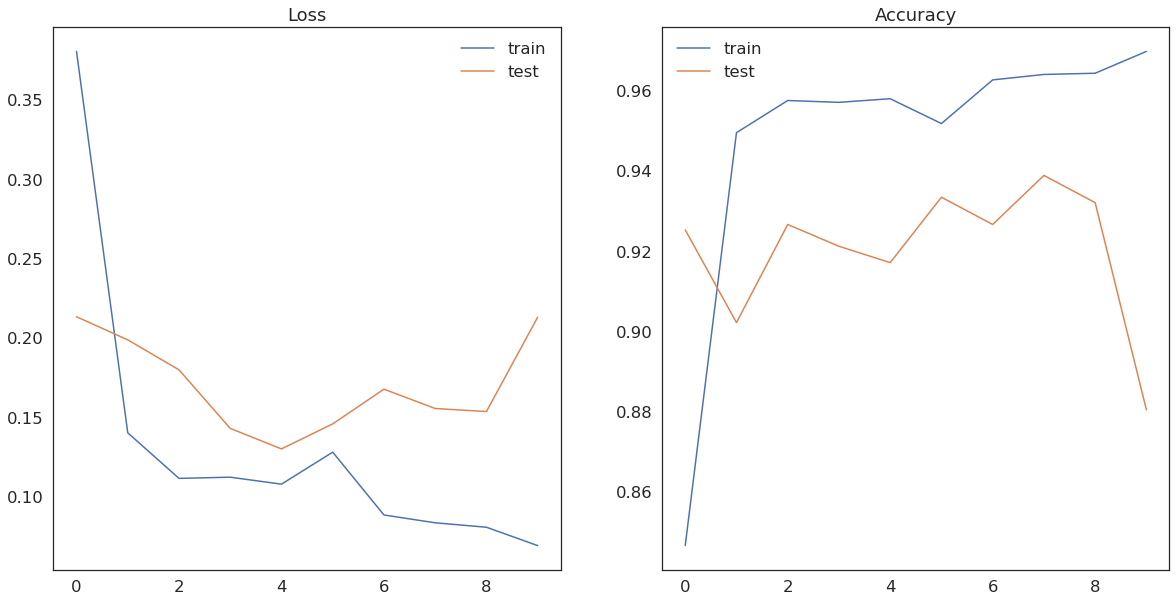

In [14]:
classifier2=run(model2)

### CNN-LSTM Network Model

In [15]:

n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [16]:
def model3():
    seed(17)
    set_seed(17)
    K.clear_session()
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] batch_size=32, epochs=10, validation_split=0.1 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
34/34 - 1s - loss: 1.3853 - accuracy: 0.4376 - val_loss: 1.0228 - val_accuracy: 0.6525
Epoch 2/10
34/34 - 0s - loss: 0.7407 - accuracy: 0.6616 - val_loss: 0.6038 - val_accuracy: 0.7203
Epoch 3/10
34/34 - 0s - loss: 0.6175 - accuracy: 0.7023 - val_loss: 0.7918 - val_accuracy: 0.6610
Epoch 4/10
34/34 - 0s - loss: 0.6122 - accuracy: 0.7278 - val_loss: 0.4998 - val_accuracy: 0.8136
Epoch 5/10
34/34 - 0s - loss: 0.4829 - accuracy: 0.7883 - val_loss: 0.3884 - val_accuracy: 0.8644
Epoch 6/10
34/34 - 0s - loss: 0.3966 - accuracy: 0.8507 - val_loss: 0.3567 - val_accuracy: 0.8559
Epoch 7/10
34/34 - 0s - loss: 0.3513 - accuracy: 0.8582 - val_loss: 0.4764 - val_accuracy: 0.8136
Epoch 8/10
34/34 - 0s - loss: 0.3363 - accuracy: 0.8601 - val_loss: 0.3412 - val_accuracy: 0.8644
Epoch 9/10
34/34 - 0s - loss: 0.2781 - accuracy: 0.8922 - val_loss: 0.2105 - val_accuracy: 0.9237
Epoch 10/10
34/34 - 0s - loss: 0.2391 - accuracy: 0.9064 - val_loss: 0.1798 - val_accuracy: 0.9322
10/10 - 0s - loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


Epoch 1/10
34/34 - 1s - loss: 1.3978 - accuracy: 0.4206 - val_loss: 0.9594 - val_accuracy: 0.6780
Epoch 2/10
34/34 - 0s - loss: 0.7641 - accuracy: 0.6484 - val_loss: 0.5962 - val_accuracy: 0.7034
Epoch 3/10
34/34 - 0s - loss: 0.6085 - accuracy: 0.7155 - val_loss: 0.5657 - val_accuracy: 0.7542
Epoch 4/10
34/34 - 0s - loss: 0.5697 - accuracy: 0.7372 - val_loss: 0.4712 - val_accuracy: 0.7966
Epoch 5/10
34/34 - 0s - loss: 0.4880 - accuracy: 0.7902 - val_loss: 0.4272 - val_accuracy: 0.8559
Epoch 6/10
34/34 - 0s - loss: 0.3777 - accuracy: 0.8497 - val_loss: 0.3806 - val_accuracy: 0.8559
Epoch 7/10
34/34 - 0s - loss: 0.3972 - accuracy: 0.8393 - val_loss: 0.3670 - val_accuracy: 0.8559
Epoch 8/10
34/34 - 0s - loss: 0.3410 - accuracy: 0.8639 - val_loss: 0.3194 - val_accuracy: 0.8814
Epoch 9/10
34/34 - 0s - loss: 0.2881 - accuracy: 0.8771 - val_loss: 0.2579 - val_accuracy: 0.8898
Epoch 10/10
34/34 - 0s - loss: 0.2552 - accuracy: 0.8998 - val_loss: 0.2270 - val_accuracy: 0.9237
10/10 - 0s - loss: 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.6s finished


Epoch 1/10
42/42 - 1s - loss: 1.2681 - accuracy: 0.4633 - val_loss: 0.8712 - val_accuracy: 0.6395
Epoch 2/10
42/42 - 0s - loss: 0.6659 - accuracy: 0.6750 - val_loss: 0.6692 - val_accuracy: 0.7143
Epoch 3/10
42/42 - 0s - loss: 0.5627 - accuracy: 0.7543 - val_loss: 0.5141 - val_accuracy: 0.7959
Epoch 4/10
42/42 - 0s - loss: 0.4651 - accuracy: 0.7997 - val_loss: 0.4029 - val_accuracy: 0.8299
Epoch 5/10
42/42 - 0s - loss: 0.4025 - accuracy: 0.8352 - val_loss: 0.4012 - val_accuracy: 0.8231
Epoch 6/10
42/42 - 0s - loss: 0.3470 - accuracy: 0.8587 - val_loss: 0.4139 - val_accuracy: 0.8503
Epoch 7/10
42/42 - 0s - loss: 0.2984 - accuracy: 0.8949 - val_loss: 0.2737 - val_accuracy: 0.8980
Epoch 8/10
42/42 - 0s - loss: 0.2811 - accuracy: 0.8866 - val_loss: 0.3259 - val_accuracy: 0.8912
Epoch 9/10
42/42 - 0s - loss: 0.2468 - accuracy: 0.9055 - val_loss: 0.2205 - val_accuracy: 0.9184
Epoch 10/10
42/42 - 0s - loss: 0.2134 - accuracy: 0.9252 - val_loss: 0.1779 - val_accuracy: 0.9320
Best: 0.906122 usin

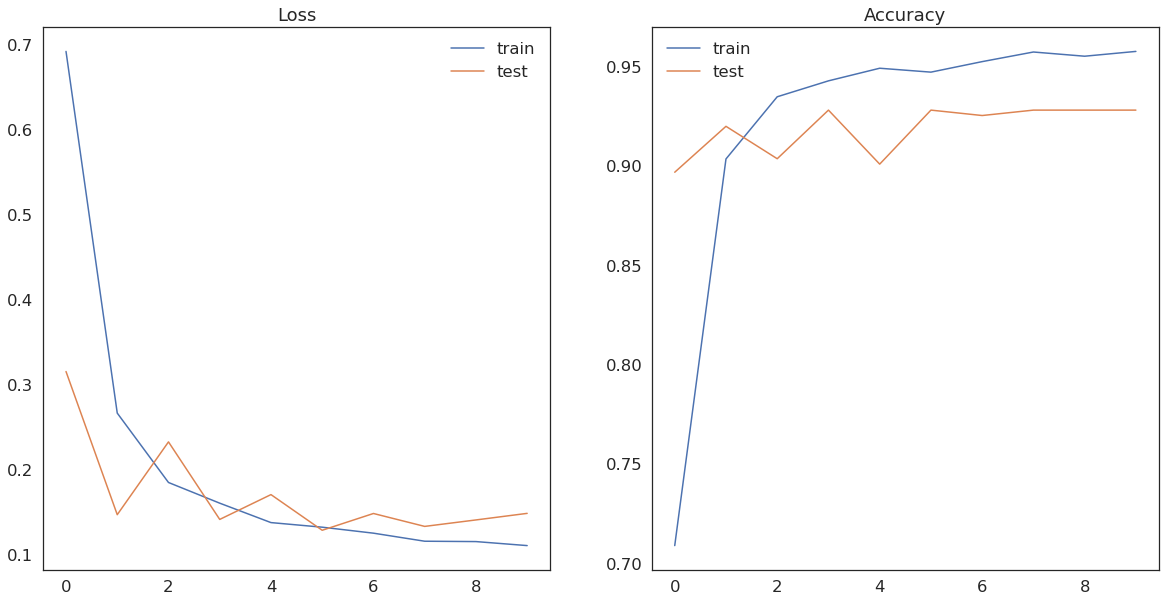

In [17]:
classifier3=run(model3)

In [18]:
classifier3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 768)         0

In [19]:

scores = classifier3.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Loss: 0.296854
Test Accuracy: 90.872073%


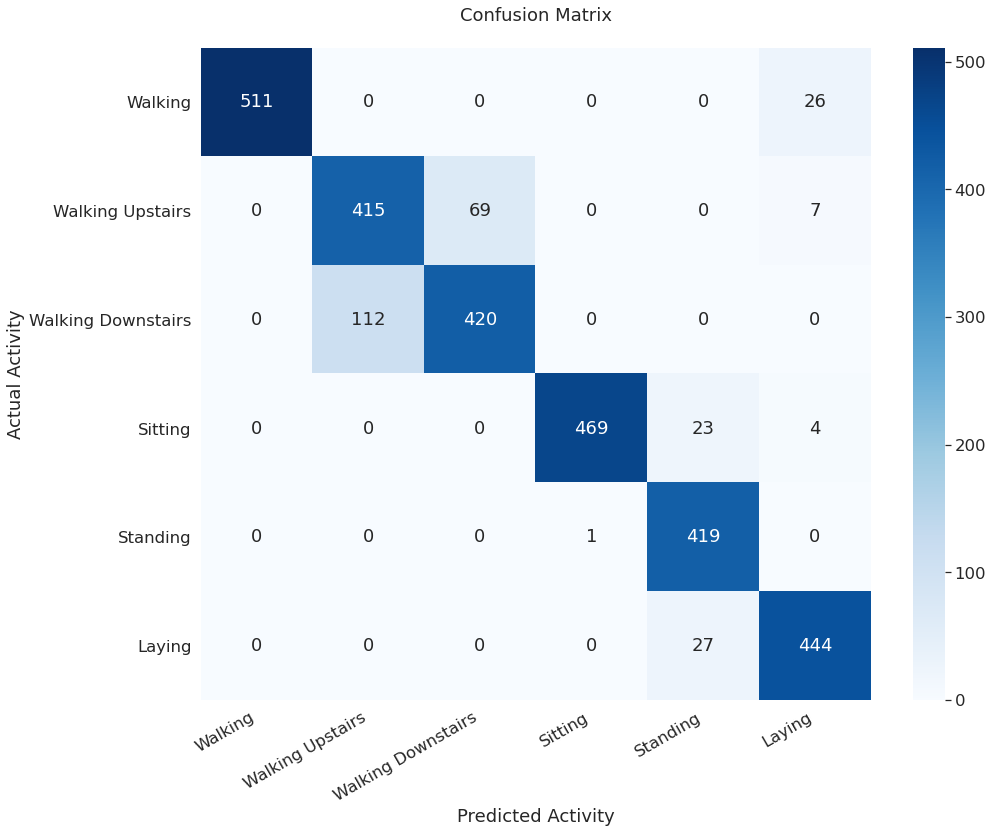

In [20]:

y_pred=classifier3.predict(X_test)
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


class_names = list(activities.values())
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)

fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")

plt.show()

In [21]:

cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
print(cr)

                    precision    recall  f1-score   support

           Walking     1.0000    0.9516    0.9752       537
  Walking Upstairs     0.7875    0.8452    0.8153       491
Walking Downstairs     0.8589    0.7895    0.8227       532
           Sitting     0.9979    0.9456    0.9710       496
          Standing     0.8934    0.9976    0.9426       420
            Laying     0.9231    0.9427    0.9328       471

          accuracy                         0.9087      2947
         macro avg     0.9101    0.9120    0.9099      2947
      weighted avg     0.9113    0.9087    0.9089      2947



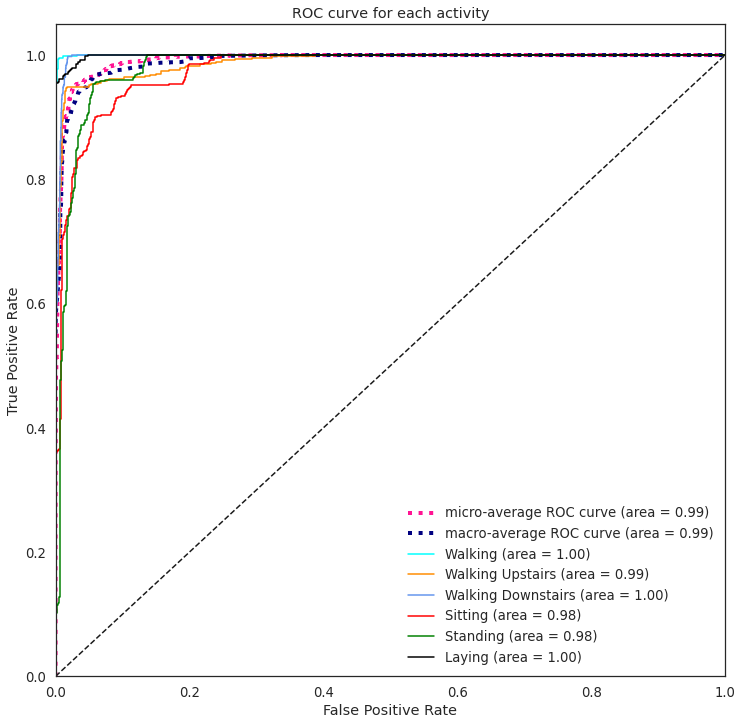

In [22]:

n_classes = 6

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.2)
plt.figure(figsize=(12,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', "red", "green", "black"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='{0} (area = {1:0.2f})'
             ''.format(activities[i+1], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each activity')
plt.legend(loc="lower right")

plt.show()